In [1]:
# Mid-fjord (re)circulation
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [ ]:
# Find the interface and vertical flux of theta
def Layer(u):
    # Layer interface, zero velocity crossing point
    uzx = u.mean(axis=(0,2)) # Z, X
    Xu = uzx.shape[1]
    itf = np.empty(Xu, dtype=int)
    itf[[0,1,-2,-1]] = 0 # Remove data at fjord head and end
    for i in range(2,Xu-2):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [ ]:
def transVol(sd):
    #/Users/weiyangbao/Documents/Model_outputs/qf-only-hourly/state_
    state01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf070tide003/state_' + str(format(sd,'03d')) + '.nc')
    state02 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf070tide003/grid_' + str(format(sd,'03d')) + '.nc')
    state1 = state01.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(24,161))
    
    
    u = state1.U.data
    w = state1.W.data
    temp = state1.Temp.data
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600


    HFacW = state02.HFacW.data[:,30:39,f:s+1] # vertical fraction of open cell at West face
    rA = state02.rA.data[30:39,f:s+1] # r face area at cell center
    itf = Layer(u)
    Vx1 = np.empty(s-f+1) # Horizontal volume transport for the upper layer
    Vx2 = np.empty(s-f+1) # Horizontal volume transport for the lower layer
    Vz = np.empty(s-f+1) # Vertical volume transport through the interface
    for i in range(s-f+1):
        it = itf[f:s+1]
        ut = u[:,:,:,f:s+1].mean(0)
        wt = w[:,:,:,f:s+1].mean(0)
        Vx1[i] = np.sum(ut[:it[i],:,i] * HFacW[:it[i],:,i] * Area[:it[i],:])
        Vx2[i] = np.sum(ut[it[i]:,:,i] * HFacW[it[i]:,:,i] * Area[it[i]:,:])
        Vz[i] = np.sum(wt[it[i],:,i] * rA[:,i])
        
    return (Vx1, Vx2, Vz)

In [ ]:
sd = np.array([9, 12, 15, 18, 30, 150]) # Sill depth
files = sorted(glob.glob('/Volumes/Extreme SSD/MITgcm outputs/qf070tide003/state*.nc'))
grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf070tide003/grid_150.nc')

# (600.0, 8400.0)
f = 6 # Control volume start index near the ice front 3
s = 88 # Control volume end index at the sill crest 42
X = grid.Xp1.data[f:s+1] / 1000
fig1, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12))
for i in range(len(sd)):
    V1, V2, Vz = transVol(sd[i])
    
    ax1.plot(X, V1, label=str(np.round(sd[i]/150, 2)))
    ax1.axvline(x=X[66],color='k',linestyle='--') # crest =24 & 66
    ax1.axvline(x=X[49],color='k',linestyle='--')
    #ax1.axvline(x=X[76],color='b',linestyle='--')
    ax1.legend(loc = 'lower left', fontsize=10, title=r'$h_s/h$')
    ax1.set_ylabel('($m^3/s$)',size = 15)
    ax1.set_ylim([1000, 5200])
    ax1.xaxis.set_visible(False) # This erases the y ticks
    ax1.set_title('(a) Upper layer horizontal volume flux', loc='left', size=15, weight='bold')

    ax2.plot(X, V2,label=str(np.round(sd[i]/150, 2)))
    ax2.axvline(x=X[66],color='k',linestyle='--')
    ax2.axvline(x=X[49],color='k',linestyle='--')
    #ax2.axvline(x=X[76],color='b',linestyle='--')
    ax2.legend(loc = 'lower left', fontsize=10, title=r'$h_s/h$')
    ax2.set_ylabel('($m^3/s$)',size = 15)
    ax2.set_ylim([-4500, -500])
    ax2.xaxis.set_visible(False) # This erases the y ticks
    ax2.set_title('(b) Lower layer horizontal volume flux', loc='left', size=15, weight='bold')
    
    ax3.plot(X,Vz,label=str(np.round(sd[i]/150, 2)))
    ax3.axvline(x=X[66],color='k',linestyle='--')
    ax3.axvline(x=X[49],color='k',linestyle='--')
    #ax3.axvline(x=X[76],color='b',linestyle='--')
    #ax3.axvline(x=X[53],color='grey',linestyle='--')
    ax3.legend(loc = 'lower left', fontsize=10, title=r'$h_s/h$')
    ax3.set_ylabel('($m^3/s$)',size = 15)
    ax3.set_ylim([-800, 200])
    ax3.set_xlabel('Down-fjord distance ($km$)', size = 15)
    ax3.set_title('(c) Vertical volume flux through interface', loc='left', size=15, weight='bold')
X[66], X[49]

In [ ]:
fig2, ax =plt.subplots(figsize=(10,7))
Hs = np.array([9, 15, 18, 30, 150]) # Sill depth
r = Hs / 150
Qout_f = np.empty(len(r))
Qout_o = np.empty(len(r))
Qin_f = np.empty(len(r))
Qin_o = np.empty(len(r))
Qz = np.empty(len(r))
for j in range(len(Hs)):
    V1, V2, Vz = transVol(Hs[j])
    Qout_f[j] = V1[50] 
    Qout_o[j] = V1[70]
    Qin_f[j] = V2[50]
    Qin_o[j] = V2[70]
    Qz[j] = Vz[50:70].sum()
    
      
ax.set_xlim([0,r[-1]])    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\frac{H_s}{H}$', size=20)
plt.ylabel(r'Volume Flux ($m^3/s$)', size=20)
ax.plot(r, Qout_f, 'o-', lw=2, label='$Q_{f1}$')
ax.plot(r, Qout_o, 'o-', lw=2, label='$Q_{oc1}$')

ax.plot(r, -Qin_f, 'o-', lw=2, label='$Q_{f2}$')
ax.plot(r, -Qin_o, 'o-', lw=2, label='$Q_{oc2}$')

ax.plot(r, -Qz, 'o-', lw=2, label='$Q_{z}$')
ax.plot(r, Qout_f-Qout_o, 'o-', lw=2, label='$Q_{r}$')
#ax.plot(r, -Qz-(Qout_f-Qout_o), lw=2, label='Qz-Qr')

ax.legend(loc = 'best', fontsize=15)

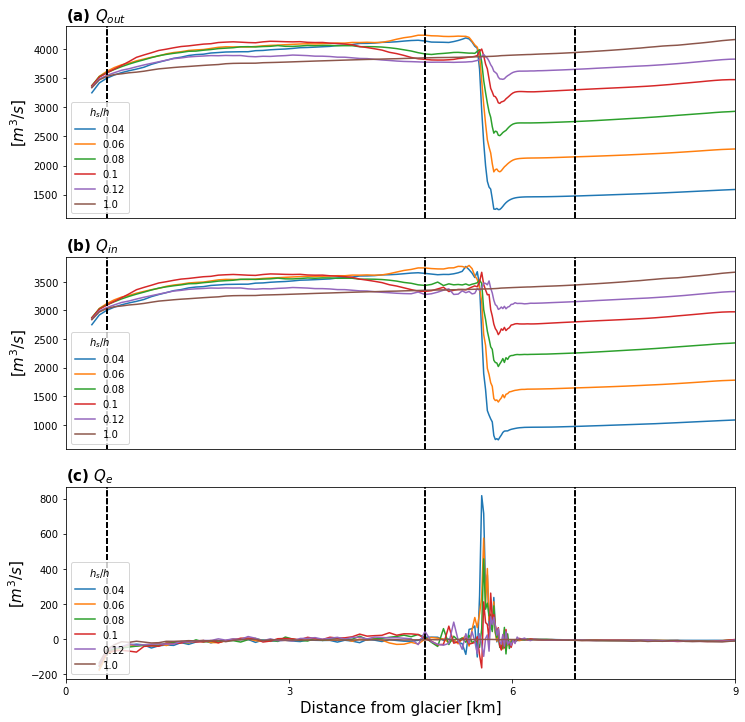

In [2]:
# TEF outputs plot
qsg = 500
hs = np.array([1, 2, 3, 4, 5, 6])
hsr = np.array([0.04, 0.06, 0.08, 0.1, 0.12, 1])
fig3, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12))
for j in range(len(hs)):
    tef = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/TEF/Qsg' + str(format(qsg,'03d')) + '_hs' + str(format(hs[j],'03d')) + '.nc')

    qin = tef.Qin.data
    qout = tef.Qout.data
    dist = tef.x_dist.data / 1000
    
    ax1.plot(dist[2:], qin[2:], label=str(hsr[j]))
    ax1.axvline(x=dist[4],color='k',linestyle='--')
    ax1.axvline(x=dist[47],color='k',linestyle='--')
    ax1.axvline(x=dist[96],color='k',linestyle='--')
    #ax1.axvline(x=X[76],color='b',linestyle='--')
    ax1.legend(loc = 'lower left', fontsize=10, title=r'$h_s/h$')
    ax1.set_ylabel('[$m^3/s$]',size = 15)
    #ax1.set_ylim([1000, 5200])
    ax1.xaxis.set_visible(False) # This erases the y ticks
    ax1.set_title('(a) $Q_{out}$', loc='left', size=15, weight='bold')

    ax2.plot(dist[2:], -qout[2:],label=str(hsr[j]))
    ax2.axvline(x=dist[4],color='k',linestyle='--')
    ax2.axvline(x=dist[47],color='k',linestyle='--')
    ax2.axvline(x=dist[96],color='k',linestyle='--')
    #ax2.axvline(x=X[76],color='b',linestyle='--')
    ax2.legend(loc = 'lower left', fontsize=10, title=r'$h_s/h$')
    ax2.set_ylabel('[$m^3/s$]',size = 15)
    #ax2.set_ylim([-4500, -500])
    ax2.xaxis.set_visible(False) # This erases the y ticks
    ax2.set_title('(b) $Q_{in}$', loc='left', size=15, weight='bold')
    
    ax3.plot(dist[3:],np.diff(qout[2:]),label=str(hsr[j]))
    ax3.axvline(x=dist[4],color='k',linestyle='--')
    ax3.axvline(x=dist[47],color='k',linestyle='--')
    ax3.axvline(x=dist[96],color='k',linestyle='--')
    #ax3.axvline(x=X[76],color='b',linestyle='--')
    #ax3.axvline(x=X[53],color='grey',linestyle='--')
    ax3.legend(loc = 'lower left', fontsize=10, title=r'$h_s/h$')
    ax3.set_ylabel('[$m^3/s$]',size = 15)
    #ax3.set_ylim([-800, 200])
    ax3.set_xlim([0, 9])
    ax3.set_xticks([0, 3, 6, 9])
    #ax3.set_xticklabels(["0","3","6","9"], size=15)
    ax3.set_xlabel('Distance from glacier [km]', size = 15)
    ax3.set_title('(c) $Q_e$', loc='left', size=15, weight='bold')
    
    

#qin, qout, dist

In [3]:
TEF = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/TEF/Qsg500_hs001.nc')
qi = TEF.Qin.data
qo = TEF.Qout.data
si = TEF.Sin.data
so = TEF.Sout.data

In [11]:
xi = 60
qi[xi]*si[xi] + qo[xi]*so[xi]

-1688.4632509465882

In [3]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig3.savefig(fig_path + '/TEF_distribution.png', dpi=200, bbox_inches='tight')

In [ ]:
Qout_f+Qin_f, Qout_o+Qin_o